In [1]:
from load_h5 import Dataset4h5
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import h5py
from scipy.fftpack import fft, fftshift, ifft
from scipy.fftpack import fftfreq
import torch

In [2]:
torch.cuda.is_available()

True

In [3]:
dataset = Dataset4h5('/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-4.4-131.341.h5', num_image=192, num_redshift=64, HII_DIM=64, rescale=False, dim=2)

dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
1000 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 192 images randomly
images loaded: (192, 1, 64, 64)
params loaded: (192, 2)
images rescaled to [0.0, 42.50267791748047]
params rescaled to [4.4, 131.341]


In [4]:
with h5py.File("/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-5.6-19.037.h5") as f:
    print(f.keys())
    print(f['redshifts_distances'])
    los = f['redshifts_distances'][:,-dataset.num_redshift:]

<KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
<HDF5 dataset "redshifts_distances": shape (2, 514), type "<f8">


In [5]:
los.shape

(2, 64)

In [6]:
dataloader = DataLoader(dataset, batch_size=192)

In [7]:
len(dataloader)

1

In [8]:
x, c = next(iter(dataloader))

In [9]:
x.shape

torch.Size([192, 1, 64, 64])

In [10]:
c.shape

torch.Size([192, 2])

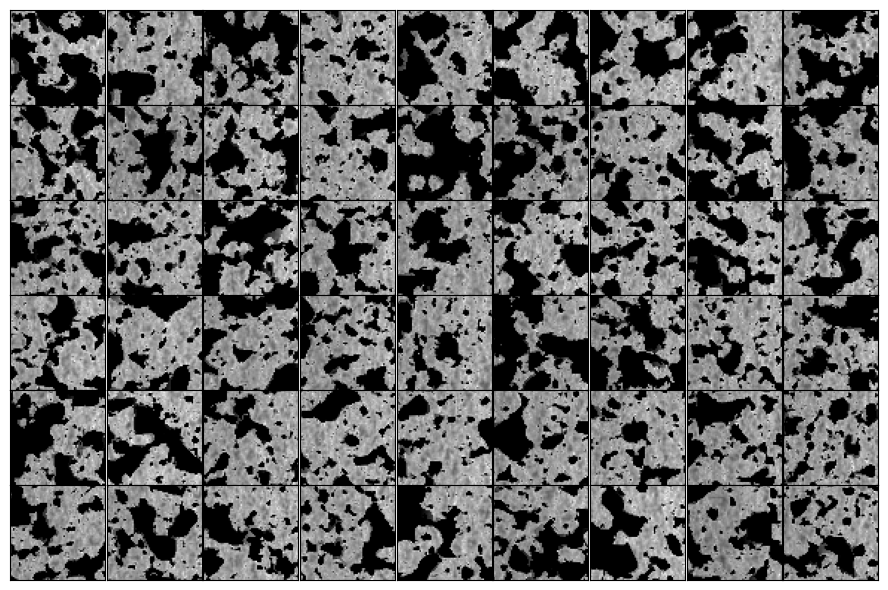

In [11]:
# for i in range(len(x)):
#     plt.imshow(x[i,0,:,0,:])
#     plt.show()
# row = 4
# col = 6
# samples = x[:,:,:,0,:]
def plot(samples, row=6, col=9):
    plt.figure(figsize = (9,6))
    for i in range(54):
        plt.subplot(row,col,i+1)
        plt.imshow(samples[i,0,:,:], cmap='gray')#, vmin=-1, vmax=1)
        plt.xticks([])
        plt.yticks([])
        # plt.show()
    # plt.suptitle('simulations')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0) 
    plt.show()
    
plot(x[:,:,:,:])

In [12]:
print(x.shape)
Tb = torch.mean(x, axis=2)
print(Tb.shape)
# Tb = torch.mean(Tb, axis=2)
# print(Tb.shape)
# print(Tb.shape)
# print(Tb[:,0,:].shape)
# print(Tb[:10, 0, :].shape)

torch.Size([192, 1, 64, 64])
torch.Size([192, 1, 64])


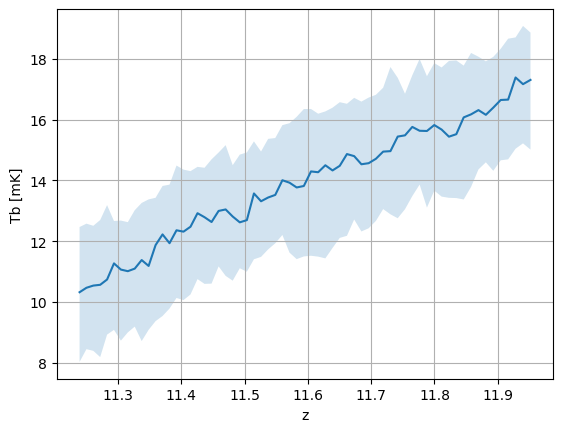

In [13]:
sigma_level = 68.27 

plt.plot(los[0,:], np.median(Tb[:,0,:], axis=0))
plt.fill_between(los[0,:], np.percentile(Tb[:,0,:], 100-sigma_level, axis=0), np.percentile(Tb[:,0,:], sigma_level, axis=0), alpha=0.2)
# for i in range(24):
#     plt.plot(los[0,:], Tb[i,0,:], lw=0.3)
# plt.plot(los[0,:], Tb[1,0,:])
# plt.plot(los[0,:], Tb[2,0,:])
# plt.yscale('log')
plt.grid()
plt.ylabel('Tb [mK]')
plt.xlabel('z')
plt.show()

In [14]:
# density_field = x[0,0,:,:]
# print(density_field.shape)
# delta_k = np.fft.fftn(density_field)
# plt.imshow(density_field)
# plt.show()
# print(delta_k.shape)
# plt.imshow(np.log10(np.abs(delta_k) ** 2))
# plt.colorbar()
# plt.show()
# delta_k = np.fft.fftshift(delta_k)
# print(delta_k.shape)
# plt.imshow(np.log10(np.abs(delta_k) ** 2))
# plt.colorbar()
# plt.show()

In [15]:
# def calc_ps(field, L):
#     ng = field.shape[0]
#     ru = np.fft.fftn(field)[0:ng//2+1, 0:ng//2+1, 0:ng//2+1]
#     ru *= 8.0 / ng**3
#     ru = np.abs(ru)**2
#     # ru[0,0,0] = 0.0
    
#     ru = np.fft.fftshift(ru)

#     kx = np.fft.rfftfreq(ng) * ng / L
#     ky = kx.copy()
#     kz = kx.copy()
#     kmin = 1/L
#     kmax = 0.5*ng/L
#     kbins = np.arange(kmin, kmax, kmin)
#     Nk = len(kbins)
    
#     kx3d, ky3d, kz3d = np.meshgrid(kx, ky, kz, indexing="ij")
#     k = np.sqrt(kx3d**2 + ky3d**2 + kz3d**2)
#     hist, edges = np.histogram(k, weights=ru, bins=Nk)
#     Pk = ng * hist / kbins**2
#     return kbins, Pk, ru

In [16]:
# field_test = x[0,0]#np.random.normal(0,1,(64,64,64))
# L = 128 # Mpc
# kbins, Pk, ru = calc_ps(field_test, L)
# print(kbins.shape)
# print(Pk.shape)

In [17]:
# plt.imshow(field_test[0])
# plt.show()

# plt.imshow(ru[0])
# plt.show()

# plt.plot(kbins, Pk*kbins**2/(4*np.pi**2))
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

In [18]:
# def compute_power_spectrum(density_field, box_size):
#     if density_field.ndim == 3:
#         Nx, Ny, Nz = density_field.shape
#         Lx, Ly, Lz = box_size
#     elif density_field.ndim == 2:
#         Nx, Ny = density_field.shape
#         Lx, Ly = box_size
#     else:
#         raise ValueError(f"density_field.dim must be 2 or 3, instead of {density_field.ndim}")
#     delta_k = np.fft.fftn(density_field)
#     # delta_k = np.fft.fftshift(delta_k)

#     if density_field.ndim == 3:
#         Pk = np.abs(delta_k) ** 2 / (Nx * Ny * Nz)
#     elif density_field.ndim ==2:
#         Pk = np.abs(delta_k) ** 2 / (Nx * Ny)
    
#     kx = np.fft.fftfreq(Nx, d=Lx / Nx)
#     ky = np.fft.fftfreq(Ny, d=Ly / Ny)

#     if density_field.ndim == 3:
#         kz = np.fft.fftfreq(Nz, d=Lz / Nz)
#         kx, ky, kz = np.meshgrid(kx, ky, kz, indexing='ij')
#         k = np.sqrt((kx**2) + (ky**2) + (kz**2))
#     elif density_field.ndim == 2:
#         kx, ky = np.meshgrid(kx, ky, indexing='ij')
#         k = np.sqrt((kx**2) + (ky**2))
    
#     # k = np.fft.fftshift(k)
#     # Pk = np.fft.fftshift(Pk)

#     k = k.flatten()
#     Pk = Pk.flatten()
    
#     mask = k > 0
#     k = k[mask]
#     Pk = Pk[mask]

#     # k_bins = np.logspace(np.log10(k.min()), np.log10(k.max()), num=40)
#     k_bins = np.linspace(k.min(), k.max(), num=50)

#     k_vals = 0.5 * (k_bins[1:] + k_bins[:-1])
#     Pk_vals = np.zeros_like(k_vals)

#     for i in range(len(k_bins) - 1):
#         bin_mask = (k >= k_bins[i]) & (k < k_bins[i+1])
#         if np.any(bin_mask):
#             Pk_vals[i] = np.mean(Pk[bin_mask])

#     return k_vals, Pk_vals

In [19]:
# image = np.random.normal(0,1,(512,512))
# print(image.ndim)
# k, ps = compute_power_spectrum(image, (128,128))
# plt.plot(k, ps)
# # plt.xscale('log')
# # plt.yscale('log')
# plt.show()

In [143]:
def calc_ps(field, L):
    ng = field.shape[0]
    ru = np.fft.fftn(field)
    
    if field.ndim == 3:
        ru = ru[0:ng//2+1, 0:ng//2+1, 0:ng//2+1]
    elif field.ndim ==2:
        ru = ru[0:ng//2+1, 0:ng//2+1]

    ru *= (2/ng)**field.ndim
    ru = np.abs(ru)**2
    
    kx = np.fft.rfftfreq(ng) * ng / L
    ky = kx.copy()
    kz = kx.copy()

    kmin = 1/L
    kmax = 0.5*ng/L
    
    kbins = np.arange(kmin, kmax, kmin)
    Nk = len(kbins)
    
    k_nd = np.meshgrid(kx, ky, kz, indexing="ij") if field.ndim == 3 else np.meshgrid(kx, ky, indexing="ij")
    
    k = np.sqrt(np.sum(np.array(k_nd)**2,axis=0))
    # k = np.sqrt(kx3d**2 + ky3d**2 + kz3d**2)

    # hist, edges = np.histogram(k, weights=ru, bins=Nk)
    # Pk = ng * hist / kbins**(field.ndim - 1)
    
    Pk = np.array([np.mean(ru[(k >= kbins[i]) & (k < kbins[i+1])]) for i in range(len(kbins)-1)])
    kbins = (kbins[:-1] + kbins[1:])/2

    return kbins, Pk

In [144]:
# x = np.random.normal(0,1,(54,1,64,64))

In [145]:
# 示例三维密度场
# Nx, Ny, Nz = 64, 64, 512  # 密度场的大小，长方体
# box_size = (128.0, 128.0, 1024.0)  # 盒子大小（单位Mpc/h），对应于 (Lx, Ly, Lz)
# plt.figure(figsize=(6, 4), dpi=100)
# k_vals_all = []
Pk_vals_all = []
for i in range(54):
    density_field = x[i,0,:,:]#np.random.randn(Nx, Ny, Nz)  # 示例密度场，可以替换为实际数据
    if density_field.ndim == 3:
        Nx, Ny, Nz = density_field.shape
        box_size = 128#(128.0, 128.0, 1024.0)
    elif density_field.ndim == 2:
        Nx, Ny = density_field.shape
        box_size = 128#(128.0, 1024.0)

    # 计算物质功率谱
    k_vals, Pk_vals = calc_ps(density_field, box_size)
    # k_vals_all.append(k_vals)
    Pk_vals_all.append(Pk_vals)

    # 计算Delta^2(k)
    Delta2_vals = k_vals**3 * Pk_vals / (2 * np.pi**2)

    # 计算 k^2 P(k) / (4 * pi^2)
    k2Pk_vals = k_vals**2 * Pk_vals / (4 * np.pi**2)

    # 绘制功率谱
    # plt.subplot(1, 1, 1)
    # plt.plot(k_vals, Pk_vals, '--', lw=0.5)#, 'b-')
    # plt.plot(k_vals, k2Pk_vals, ':', lw=0.1)#, 'b-')

# plt.xlabel('k [Mpc$^{-1}$]')
# plt.ylabel(r'P(k) [Mpc$^3$]')
# plt.title('Simulations Power Spectrum')
# plt.grid(True)

# k_vals_all = np.array(k_vals_all)
# print(k_vals_all.shape)
Pk_vals_all = np.array(Pk_vals_all)
# print(Pk_vals_all.shape)

# sigma_level = 68.27 
# plt.plot(k_vals, np.median(Pk_vals_all, axis=0), 'k-')
# plt.fill_between(k_vals, np.percentile(Pk_vals_all, 100-sigma_level, axis=0), np.percentile(Pk_vals_all, sigma_level, axis=0), alpha=0.5, color='C0')

# plt.plot(k_vals, Pk_vals_all.mean(axis=0), 'k-', lw=1, label='mean')
# k_vals_all_sim = k_vals_all
Pk_vals_all_sim = Pk_vals_all
# plt.xscale('log')
# plt.yscale('log')

# plt.tight_layout()
# plt.legend()
# plt.show()

# # plt.subplot(2, 1, 2)
# plt.plot(k_vals, Delta2_vals, 'r-', label='$\\Delta^2(k) = \\frac{k^3 P(k)}{2\\pi^2}$')
# plt.plot(k_vals, k2Pk_vals, 'g--', label='$\\frac{k^2 P(k)}{4\\pi^2}$')
# plt.xlabel('k [h/Mpc]')
# plt.ylabel('Power')
# plt.title('Normalized Power Spectrum')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(xmin=1e-2)
# plt.legend()
# plt.grid(True)

In [146]:
ll -lth outputs

total 879M
-rw-r--r-- 1 bxia34 3.1M Jun  5 00:11 0604-2353.npy
-rw-r--r-- 1 bxia34 848M Jun  4 23:53 model_state.pth
drwxr-xr-x 9 bxia34 4.0K Jun  4 23:05 logs/
-rw-r--r-- 1 bxia34 3.1M Jun  4 20:41 test_0_0.npy
-rw-r--r-- 1 bxia34 3.1M Jun  4 19:45 test_8_038.npy
-rw-r--r-- 1 bxia34 3.1M Jun  4 18:00 test_2_506.npy
-rw-r--r-- 1 bxia34 3.1M Jun  4 17:01 0604-1643.npy
-rw-r--r-- 1 bxia34 3.1M May 29 15:08 0529-1450.npy
-rw-r--r-- 1 bxia34 385K May 29 14:41 0529-1439.npy
-rw-r--r-- 1 bxia34 385K May 29 01:51 0529-0149.npy
-rw-r--r-- 1 bxia34 385K May 29 01:12 0529-0110.npy
-rw-r--r-- 1 bxia34 385K May 28 23:38 0528-2336.npy
-rw-r--r-- 1 bxia34 385K May 28 23:03 0528-2301.npy
-rw-r--r-- 1 bxia34 385K May 28 17:34 0528-1732.npy
-rw-r--r-- 1 bxia34 385K May 28 16:26 0528-1624.npy
-rw-r--r-- 1 bxia34 385K May 28 14:35 0528-1433.npy
-rw-r--r-- 1 bxia34 385K May 28 14:17 0528-1416.npy
-rw-r--r-- 1 bxia34 385K May 27 21:55 0527-2152.npy
-rw-r--r-- 1 bxia34 3.1M May 27 21:34 0527-2117.npy
-rw-r-

In [147]:
# x_sample = np.load("outputs/0527-1951.npy")
x_sample = np.load("outputs/test_8_038.npy")
print(x_sample.shape)
x_sample = torch.from_numpy(x_sample)
print(x_sample.shape)

(192, 1, 64, 64)
torch.Size([192, 1, 64, 64])


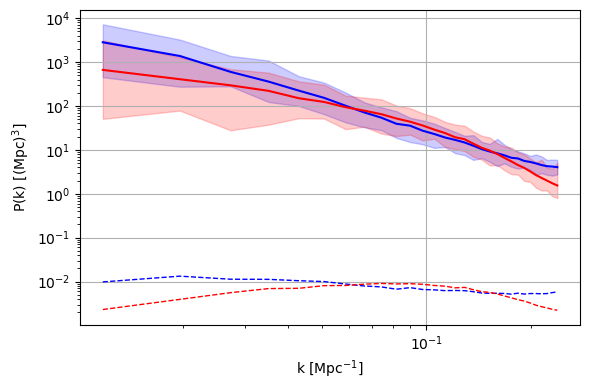

In [148]:
# 示例三维密度场
# Nx, Ny, Nz = 64, 64, 512  # 密度场的大小，长方体
# box_size = (128.0, 128.0, 1024.0)  # 盒子大小（单位Mpc/h），对应于 (Lx, Ly, Lz)
plt.figure(figsize=(6, 4), dpi=100)
k_vals_all = []
Pk_vals_all = []
for i in range(192):
    
    density_field = (x_sample[i,0,:,:]+1)/2 * 80#np.random.randn(Nx, Ny, Nz)  # 示例密度场，可以替换为实际数据
    if density_field.dim() == 3:
        Nx, Ny, Nz = density_field.shape
        box_size = 128.0
    elif density_field.dim() == 2:
        Nx, Ny = density_field.shape
        box_size = 128.0

    # 计算物质功率谱
    k_vals, Pk_vals = calc_ps(density_field, box_size)
    k_vals_all.append(k_vals)
    Pk_vals_all.append(Pk_vals)

    # 计算Delta^2(k)
    # Delta2_vals = k_vals**3 * Pk_vals / (2 * np.pi**2)

    # 计算 k^2 P(k) / (4 * pi^2)
    # k2Pk_vals = k_vals**2 * Pk_vals / (4 * np.pi**2)

    # 绘制功率谱
    # plt.subplot(1, 1, 1)
    # plt.plot(k_vals, Pk_vals, '--', lw=0.5)#, 'b-')

plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel(r'P(k) [(Mpc)$^3$]')
# plt.title('Power Spectrum for random $\log T_{vir}$, $\zeta$')
# plt.title('Power Spectrum for $\log T_{vir}$, $\zeta$ =' + f" {c[0].numpy()}")
plt.grid(True)

# k_vals_all = np.array(k_vals_all)
# print(k_vals_all.shape)
Pk_vals_all_diffusion = np.array(Pk_vals_all)
# print(Pk_vals_all.shape)
    # plt.subplot(2, 1, 2)
    # plt.loglog(k_vals, Delta2_vals, 'r-', label='$\\Delta^2(k) = \\frac{k^3 P(k)}{2\\pi^2}$')
    # plt.loglog(k_vals, k2Pk_vals, 'g--', label='$\\frac{k^2 P(k)}{4\\pi^2}$')
    # plt.xlabel('k [h/Mpc]')
    # plt.ylabel('Power')
    # plt.title('Normalized Power Spectrum')
    # # plt.legend()
    # plt.grid(True)
sigma_level = 0

plt.plot(k_vals, np.median(Pk_vals_all_sim, axis=0), 'b-', label='sim')
plt.plot(k_vals, k_vals**2/(4*np.pi**2)*np.median(Pk_vals_all_sim, axis=0), 'b--', lw=1)
plt.fill_between(k_vals, np.percentile(Pk_vals_all_sim, 100-sigma_level, axis=0), np.percentile(Pk_vals_all_sim, sigma_level, axis=0), alpha=0.2, color='b')


plt.plot(k_vals, np.median(Pk_vals_all_diffusion, axis=0), 'r-', label='diffusion')
plt.plot(k_vals, k_vals**2/(4*np.pi**2)*np.median(Pk_vals_all_diffusion, axis=0), 'r--', lw=1)
plt.fill_between(k_vals, np.percentile(Pk_vals_all_diffusion, 100-sigma_level, axis=0), np.percentile(Pk_vals_all_diffusion, sigma_level, axis=0), alpha=0.2, color='r')
# plt.plot(k_vals_all.mean(axis=0), Pk_vals_all.mean(axis=0), 'r--', lw=4, label="samples' mean")
# plt.plot(k_vals_all_sim.mean(axis=0), Pk_vals_all_sim.mean(axis=0), 'k-', lw=1, label="simulations' mean")

plt.xscale('log')
plt.yscale('log')

# plt.legend()
plt.tight_layout()
plt.show()

torch.Size([192, 1, 64, 64])


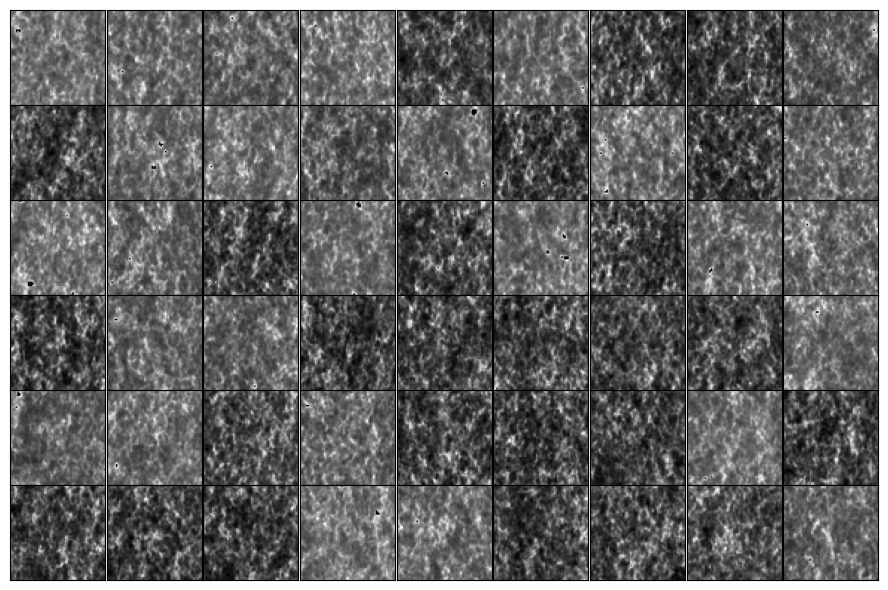

In [135]:
# for i in range(24):
#     plt.imshow(x_sample[i,0])
#     plt.show()
print(x_sample.shape)
plot(x_sample)

x_sample.shape = torch.Size([192, 1, 64, 64])
x.shape = torch.Size([192, 1, 64, 64])
x_sample tensor(1.1114) tensor(-1.1104)
x_sample tensor(1.1114) tensor(-1.1104)
Tb tensor(24.2530) tensor(0.)


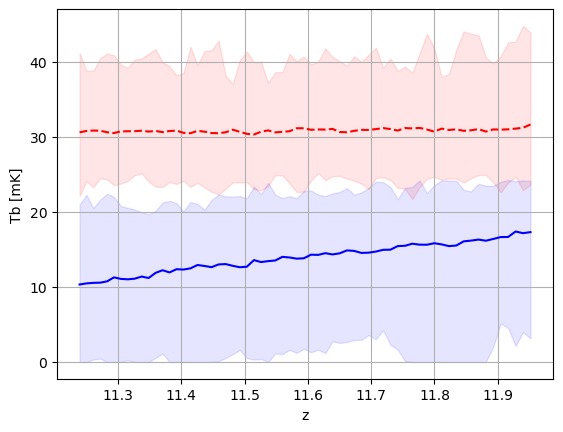

In [136]:
print("x_sample.shape =", x_sample.shape)
print("x.shape =", x.shape)
print("x_sample", x_sample.max(), x_sample.min())
x_sample_truc = x_sample#torch.where(x_sample < -1, -1, x_sample)
print("x_sample", x_sample_truc.max(), x_sample_truc.min())
Tb_sample = (x_sample_truc.mean(axis=2) + 1) / 2 *80
print("Tb", Tb.max(), Tb.min())
plt.plot(los[0,:], np.median(Tb[:,0,:], axis=0),'b-', label="simulations' average")
plt.plot(los[0,:], np.median(Tb_sample[:,0,:], axis=0),'r--', label="samples' average")

# plt.plot(los[0,:], Tb[:,0,:].mean(axis=0))
plt.fill_between(los[0,:], np.percentile(Tb[:,0,:], 100-sigma_level, axis=0), np.percentile(Tb[:,0,:], sigma_level, axis=0), alpha=0.1, color='b')

plt.fill_between(los[0,:], np.percentile(Tb_sample[:,0,:], 100-sigma_level, axis=0), np.percentile(Tb_sample[:,0,:], sigma_level, axis=0), alpha=0.1, color='r')
# for i in range(24):
#     plt.plot(los[0,:], Tb_sample[i,0,:], lw=0.3)
# plt.plot(los[0,:], Tb[1,0,:])
# plt.plot(los[0,:], Tb[2,0,:])
# plt.yscale('log')
# plt.title('Global signal for $\log T_{vir}$, $\zeta$ =' + f" {c[0].numpy()}")
# plt.title('Global signal for random $\log T_{vir}$, $\zeta$')
plt.ylabel('Tb [mK]')
plt.xlabel('z')
plt.grid()
# plt.legend()
plt.show()

In [137]:
# # import matplotlib.image as mpimg
# import numpy as np
# import scipy.stats as stats
# import matplotlib.pyplot as pl

# # image = mpimg.imread("clouds.png")
# image = np.random.normal(0,1,(64,64))
# # x = np.arange(64)
# # image_x, image_y = np.meshgrid(np.sin(x), np.cos(x))
# # image = image_x * image_y #+ np.random.normal(0,0.1,image_x.shape)
# print(np.shape(image))
# # print(image)
# # pl.imshow(image)
# # pl.show()

# npix = image.shape[0]

# fourier_image = np.fft.fftn(image)
# fourier_amplitudes = np.abs(fourier_image)**2

# kfreq = np.fft.fftfreq(npix) * npix
# kfreq2D = np.meshgrid(kfreq, kfreq)
# # kfreq2D = np.meshgrid(kfreq, kfreq, kfreq)
# knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
# # knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2 + kfreq2D[2]**2)

# knrm = knrm.flatten()
# fourier_amplitudes = fourier_amplitudes.flatten()

# kbins = np.arange(0.5, npix//2+1, 1.)
# kvals = 0.5 * (kbins[1:] + kbins[:-1])
# Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes, statistic="mean",bins = kbins)
# Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

# print("kbins.max =", kvals.max()/128)
# pl.loglog(kvals/128, Abins)
# pl.xlabel("$k$")
# pl.ylabel("$P(k)$")
# pl.tight_layout()
# pl.show()
# # pl.savefig("cloud_power_spectrum.png", dpi = 300, bbox_inches = "tight")

In [138]:
# def calc_ps(field, L):
#     ng = field.shape[0]
#     ru = np.fft.fftn(field)[0:ng//2+1, 0:ng//2+1, 0:ng//2+1]
#     # ru = np.fft.fftn(field)[0:ng//2+1, 0:ng//2+1]
#     ru *= 8.0 / ng**3
#     # ru *= 4.0 / ng**2
#     ru = np.abs(ru)**2
#     #ru[0,0,0] = 0.0
#     ru = np.fft.fftshift(ru)
    
#     kx = np.fft.rfftfreq(ng) * ng / L
#     ky = kx.copy()
#     kz = kx.copy()
#     kmin = 1/L
#     kmax = 0.5*ng/L #kx.max() #
#     kbins = np.arange(kmin, kmax, kmin)
#     Nk = len(kbins)
    
#     kx3d, ky3d, kz3d = np.meshgrid(kx, ky, kz, indexing="ij")
#     # kx3d, ky3d = np.meshgrid(kx, ky, indexing="ij")
#     k = np.sqrt(kx3d**2 + ky3d**2 + kz3d**2)
#     # k = np.sqrt(kx3d**2 + ky3d**2)
#     hist, edges = np.histogram(k, weights=ru, bins=Nk)
#     Pk = ng * hist / kbins**2
#     return kbins, Pk
# def calc_ps(field, L):
#     ng = field.shape[0]
#     ru = np.fft.fftn(field)
#     # ru = np.fft.fftshift(ru)
#     # plt.imshow(ru[0])
#     # plt.show()
#     if field.ndim == 3:
#         ru = ru[0:ng//2+1, 0:ng//2+1, 0:ng//2+1]
#     elif field.ndim ==2:
#         ru = ru[0:ng//2+1, 0:ng//2+1]

#     # plt.imshow(ru[0])
#     # plt.show()
#     ru *= (2/ng)**field.ndim
#     ru = np.abs(ru)**2
#     # plt.imshow(ru[0])
#     # plt.show()
#     #ru[0,0,0] = 0.0
    
#     kx = np.fft.rfftfreq(ng) * ng / L
#     ky = kx.copy()
#     kz = kx.copy()

#     kmin = 1/L
#     kmax = 0.5*ng/L
    
#     print("ng =", ng)
#     print("kmin =", kmin)
#     print("kmax =", kmax)
#     kbins = np.arange(kmin, kmax, kmin)
#     Nk = len(kbins)
#     print("Nk =", Nk)
    
#     k_nd = np.meshgrid(kx, ky, kz, indexing="ij") if field.ndim == 3 else np.meshgrid(kx, ky, indexing="ij")
    
#     k = np.sqrt(np.sum(np.array(k_nd)**2,axis=0))

#     # k = np.sqrt(kx3d**2 + ky3d**2 + kz3d**2)
#     hist, edges = np.histogram(k, weights=ru, bins=Nk)
#     Pk = ng * hist / kbins**(field.ndim - 1)
#     return kbins, Pk

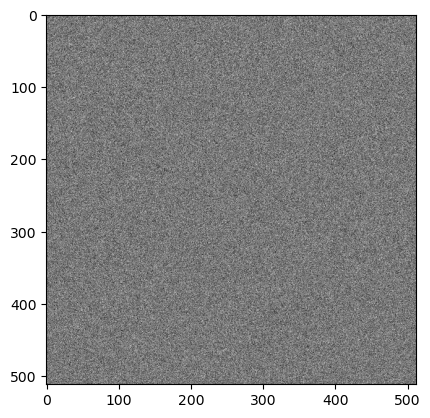

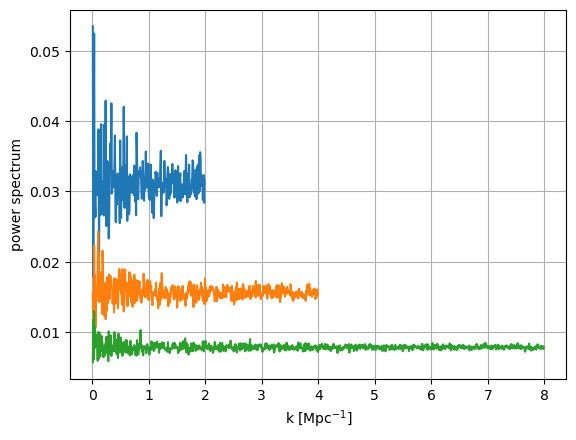

In [139]:
image = np.random.normal(0,1,(512,512))
image_1 = np.random.normal(0,1,(1024,1024))
image_2 = np.random.normal(0,1,(2048,2048))
# x = np.arange(64)
# image_x, image_y, image_z = np.meshgrid(np.sin(x), np.cos(2*x), np.sin(3*x)*np.cos(5*x))
# image = image_x * image_y * image_z #+ np.random.normal(0,0.1,image_x.shape)

k, ps = calc_ps(torch.tensor(image), 128)
k_1, ps_1 = calc_ps(torch.tensor(image_1), 128)
k_2, ps_2 = calc_ps(torch.tensor(image_2), 128)
# print("k.max() =", k.max())
plt.imshow(image, cmap='gray')
plt.show()

plt.plot(k, ps)
plt.plot(k_1, ps_1)
plt.plot(k_2, ps_2)
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel('power spectrum')
# plt.xscale('log')
# plt.yscale('log')
plt.grid()
plt.show()